**Deep Learning Approach with LSTM**

Our deep learning approach uses a bidirectional LSTM (Long Short-Term Memory) model to predict tweet locations based on the text content. Here are the first few components and steps:

*   Load preprocessed data from "tweets_country_region.csv"
*   Encode regions using LabelEncoder
Tokenize and pad text sequences

We then attempt different methods to optimize the architecture and data for the train-test split.


## First Attempt with just LSTM

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Load country region data and fill missing
tweets_final = pd.read_csv("tweets_country_region.csv")
tweets_final['region'] = tweets_final['region'].fillna('Unknown')

# Encode region variable
le = LabelEncoder()
tweets_final['region_encoded'] = le.fit_transform(tweets_final['region'])

max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_final['text'])
sequences = tokenizer.texts_to_sequences(tweets_final['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_categorical = to_categorical(tweets_final['region_encoded'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

# Build the Sequential LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# test accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

predictions = model.predict(X_test)
predicted_regions = np.argmax(predictions, axis=1)
actual_regions = np.argmax(y_test, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(actual_regions, predicted_regions, target_names=le.classes_))

# Class distribution
print("\nClass distribution in the test set:")
print(pd.Series(le.inverse_transform(actual_regions)).value_counts())

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.3203 - loss: 1.6407 - val_accuracy: 0.3827 - val_loss: 1.5204
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.3898 - loss: 1.5055 - val_accuracy: 0.3883 - val_loss: 1.4840
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - accuracy: 0.5173 - loss: 1.2277 - val_accuracy: 0.3743 - val_loss: 1.6175
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.6718 - loss: 0.8524 - val_accuracy: 0.4078 - val_loss: 1.7467
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 243ms/step - accuracy: 0.8073 - loss: 0.5781 - val_accuracy: 0.3855 - val_loss: 2.0174
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 252ms/step - accuracy: 0.8981 - loss: 0.3509 - val_accuracy: 0.4050 - val_loss: 2.2630
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.9390 - loss: 0.2461 - val_accuracy: 0.3911 - val_loss: 2.4014
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3955 - loss: 1.4976
Test accuracy: 0.390

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Second Attempt with SMOTE

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

tweets_final = pd.read_csv("tweets_country_region.csv")

tweets_final['region'] = tweets_final['region'].fillna('Unknown')

le = LabelEncoder()
tweets_final['region_encoded'] = le.fit_transform(tweets_final['region'])

max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_final['text'])
sequences = tokenizer.texts_to_sequences(tweets_final['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, tweets_final['region_encoded'], test_size=0.2, random_state=42, stratify=tweets_final['region_encoded'])

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

# Sparse categorical cross-entropy uses category index of most likely matching category
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

predictions = model.predict(X_test)
predicted_regions = le.inverse_transform(np.argmax(predictions, axis=1))

print("\nClassification Report:")
print(classification_report(y_test, np.argmax(predictions, axis=1),
                          target_names=le.classes_))

# Print confusion details
print("\nDetailed Predictions Analysis:")
for region in le.classes_:
    true_positives = sum((le.inverse_transform([y_test.iloc[i]])[0] == region) &
                        (predicted_regions[i] == region)
                        for i in range(len(y_test)))
    false_positives = sum((le.inverse_transform([y_test.iloc[i]])[0] != region) &
                         (predicted_regions[i] == region)
                         for i in range(len(y_test)))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    print(f"\n{region}:")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"Precision: {precision:.2f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 250ms/step - accuracy: 0.1954 - loss: 1.7613 - val_accuracy: 0.2149 - val_loss: 2.2025
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.3343 - loss: 1.5958 - val_accuracy: 0.1342 - val_loss: 2.7813
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 83s 253ms/step - accuracy: 0.5134 - loss: 1.2531 - val_accuracy: 0.3565 - val_loss: 2.0465
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 245ms/step - accuracy: 0.6628 - loss: 0.9158 - val_accuracy: 0.1292 - val_loss: 3.7144
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 91s 287ms/step - accuracy: 0.7776 - loss: 0.6614 - val_accuracy: 0.1553 - val_loss: 4.2451
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 85s 299ms/step - accuracy: 0.8373 - loss: 0.5003 - val_accuracy: 0.2000 - val_loss: 4.7211
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.2819 - loss: 1.7295
Test accuracy: 0.2946
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step

Classification Report:
              precision    recall  f1-score   support

      Afri

## Third Attempt with Categorical Encoding and SMOTE removed

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

tweets_final = pd.read_csv("tweets_country_region.csv")

tweets_final['region'] = tweets_final['region'].fillna('Unknown')

le = LabelEncoder()
tweets_final['region_encoded'] = le.fit_transform(tweets_final['region'])

max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_final['text'])
sequences = tokenizer.texts_to_sequences(tweets_final['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_categorical = to_categorical(tweets_final['region_encoded'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

predictions = model.predict(X_test)
predicted_regions = le.inverse_transform(np.argmax(predictions, axis=1))
actual_regions = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1),
                          np.argmax(predictions, axis=1),
                          target_names=le.classes_))

# Print region-wise analysis
print("\nRegion-wise Analysis:")
for idx, region in enumerate(le.classes_):
    true_pos = sum((np.argmax(y_test, axis=1) == idx) &
                   (np.argmax(predictions, axis=1) == idx))
    false_pos = sum((np.argmax(y_test, axis=1) != idx) &
                    (np.argmax(predictions, axis=1) == idx))

    print(f"\n{region}:")
    print(f"True Positives: {true_pos}")
    print(f"False Positives: {false_pos}")
    print(f"Precision: {true_pos/(true_pos + false_pos) if (true_pos + false_pos) > 0 else 0:.2f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 351ms/step - accuracy: 0.3228 - loss: 1.6288 - val_accuracy: 0.3827 - val_loss: 1.5218
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step - accuracy: 0.3855 - loss: 1.5066 - val_accuracy: 0.3966 - val_loss: 1.4936
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - accuracy: 0.5809 - loss: 1.1243 - val_accuracy: 0.4358 - val_loss: 1.6047
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 272ms/step - accuracy: 0.6999 - loss: 0.7930 - val_accuracy: 0.3855 - val_loss: 1.7818
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 379ms/step - accuracy: 0.7767 - loss: 0.6193 - val_accuracy: 0.3827 - val_loss: 2.0093
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 297ms/step - accuracy: 0.8221 - loss: 0.4832 - val_accuracy: 0.3771 - val_loss: 2.3234
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.8671 - loss: 0.3961 - val_accuracy: 0.3687 - val_loss: 2.7033
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.3996 - loss: 1.4764
Test Accuracy: 0.41

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Final Attempt with GloVe Embeddings, Attentional Layer, and Learning Rate Scheduler

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.3478 - loss: 1.6789 - val_accuracy: 0.3240 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3620 - loss: 1.5526 - val_accuracy: 0.3240 - val_loss: 1.5503 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3534 - loss: 1.5580 - val_accuracy: 0.3240 - val_loss: 1.5119 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3675 - loss: 1.4999 - val_accuracy: 0.3631 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4210 - loss: 1.4657 - val_accuracy: 0.3827 - val_loss: 1.4355 - learning_rate: 0.0010
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4031 - loss: 1.4556 - val_accuracy: 0.3520 - val_loss: 1.4393 - learning_rate: 0.0010
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4305 - loss: 1.4138 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


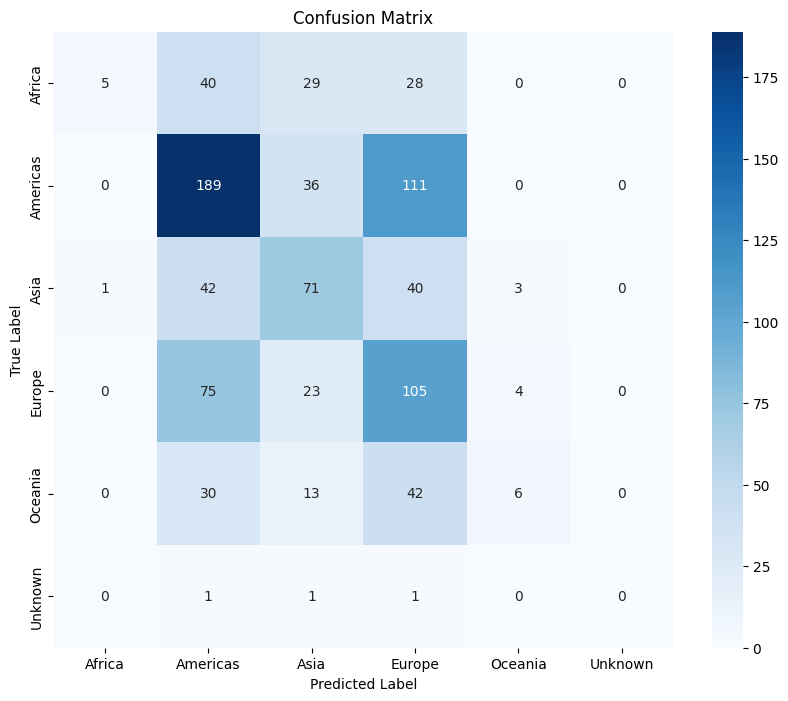


Detailed Region Analysis:

Africa:
Precision: 0.83
Recall: 0.05
Support: 102

Americas:
Precision: 0.50
Recall: 0.56
Support: 336

Asia:
Precision: 0.41
Recall: 0.45
Support: 157

Europe:
Precision: 0.32
Recall: 0.51
Support: 207

Oceania:
Precision: 0.46
Recall: 0.07
Support: 91

Unknown:
Precision: 0.00
Recall: 0.00
Support: 3


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tweets_final = pd.read_csv("tweets_country_region.csv")
tweets_final['region'] = tweets_final['region'].fillna('Unknown')

le = LabelEncoder()
tweets_final['region_encoded'] = le.fit_transform(tweets_final['region'])

max_words = 20000
max_length = 150

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_final['text'])
sequences = tokenizer.texts_to_sequences(tweets_final['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_categorical = to_categorical(tweets_final['region_encoded'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42, stratify=tweets_final['region_encoded'])

# Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with attention
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    AttentionLayer(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

# Learning rate scheduler
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

predictions = model.predict(X_test)
predicted_regions = le.inverse_transform(np.argmax(predictions, axis=1))
actual_regions = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1),
                          np.argmax(predictions, axis=1),
                          target_names=le.classes_))

# Create confusion matrix heatmap
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed metrics
print("\nDetailed Region Analysis:")
for idx, region in enumerate(le.classes_):
    true_pos = cm[idx][idx]
    false_pos = sum(cm[:,idx]) - true_pos
    false_neg = sum(cm[idx,:]) - true_pos

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0

    print(f"\n{region}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Support: {sum(cm[idx,:])}")

## Applying Previous Attempt on Training Data (Test for Overfit)

112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 282ms/step - accuracy: 0.4874 - loss: 1.2682
Training accuracy: 0.4925
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.4308 - loss: 1.3999
Test accuracy: 0.4196
112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step

Training Data Classification Report:
              precision    recall  f1-score   support

      Africa       0.49      0.05      0.09       405
    Americas       0.55      0.65      0.59      1341
        Asia       0.53      0.56      0.54       628
      Europe       0.39      0.57      0.47       828
     Oceania       0.62      0.13      0.22       364
     Unknown       0.00      0.00      0.00        14

    accuracy                           0.49      3580
   macro avg       0.43      0.33      0.32      3580
weighted avg       0.51      0.49      0.46      3580



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


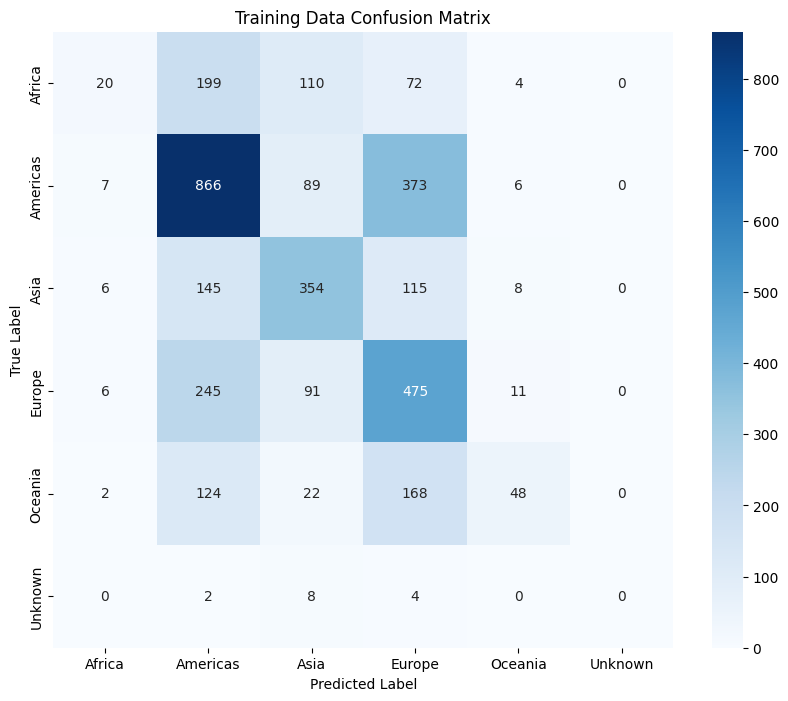


Detailed Region Analysis (Training Data):

Africa:
Precision: 0.49
Recall: 0.05
Support: 405

Americas:
Precision: 0.55
Recall: 0.65
Support: 1341

Asia:
Precision: 0.53
Recall: 0.56
Support: 628

Europe:
Precision: 0.39
Recall: 0.57
Support: 828

Oceania:
Precision: 0.62
Recall: 0.13
Support: 364

Unknown:
Precision: 0.00
Recall: 0.00
Support: 14


In [10]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Evaluate on test data (unseen)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions on training data
train_predictions = model.predict(X_train)
train_predicted_regions = le.inverse_transform(np.argmax(train_predictions, axis=1))
train_actual_regions = le.inverse_transform(np.argmax(y_train, axis=1))

print("\nTraining Data Classification Report:")
print(classification_report(np.argmax(y_train, axis=1),
                          np.argmax(train_predictions, axis=1),
                          target_names=le.classes_))

train_cm = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_predictions, axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Training Data Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nDetailed Region Analysis (Training Data):")
for idx, region in enumerate(le.classes_):
    true_pos = train_cm[idx][idx]
    false_pos = sum(train_cm[:,idx]) - true_pos
    false_neg = sum(train_cm[idx,:]) - true_pos

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0

    print(f"\n{region}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Support: {sum(train_cm[idx,:])}")